In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import jax 
from jax import jit
from jax.config import config
import random
config.update('jax_enable_x64', True)  # often needed for LBFGS that requires high-precision

import jax.numpy as jnp
import numpy as np
import pandas as pd
import pylab as plts
import pylab as plt
from functools import partial
from sklearn.model_selection import train_test_split

In [ ]:
RANDOM_SEED = 2022
BATCH_SIZE = 1024 * 4
TEST_RATIO = 0.1
LATENT_DIM = 4
TRAIN_NEG = 4
LAMBDA = 0

INTERATION_NUM = 50
LEARNING_RATE = 1

In [ ]:
path = "drive/MyDrive/DSA4212/Assignment2/ml-1m/"
ratings = pd.read_csv(path+"ratings.dat", sep="::", header = None, names = ["UserID", "MovieID", "Rating", "Timestamp"])

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


## Preprocessing

In [ ]:
def data_splition(rating_df, ratio):
	'''
	Removing the duplicate indices, and splitting the train data and test
	Input:
	Output: train_df and test_df
	'''
	# randomly select one row for each movie
	tmp = rating_df.groupby("MovieID").apply(lambda x: x.sample(1)).index 
	midx = [t[1] for t in tmp]
	# randomly select one row for each user
	tmp = rating_df.groupby("UserID").apply(lambda x: x.sample(1)).index
	uidx = [t[1] for t in tmp]
	# combine and drop duplicate indices
	idx = set(midx + uidx)

	remain = set(rating_df.index) - idx
	test_idx = np.random.choice(list(remain), int(ratio * rating_df.shape[0]), replace = False)
	train_idx = list(set(rating_df.index) - set(test_idx))

	train = rating_df.iloc[train_idx, :]
	test = rating_df.iloc[test_idx, :]
	return train, test

def create_training_matrix(train_df):
	R = train_df.pivot("UserID", "MovieID", "Rating")
	n, m = R.shape
	return R, n, m

def generate_training_samples(train_matrix):
	train_matrix = np.array(train_matrix)
	all_idx = np.argwhere(~np.isnan(train_matrix)) # (u,i) pair
	ratings_list = train_matrix[all_idx[:,0], all_idx[:,1]] # label
	return all_idx, ratings_list

def generate_test_samples(test_df):
	R_test = test_df.pivot("UserID", "MovieID", "Rating")
	test_idx = R_test.stack().index
	mid = list(R.columns)
	uid = list(R.index)
	ulist = []
	for i in test_idx: 
		ulist.append(uid.index(i[0]))
	flist = []
	for i in test_idx:
		flist.append(mid.index(i[1]))

	test_array = np.array(R_test)
	test_all_idx = np.argwhere(~np.isnan(test_array)).T
	ratings_test = test_array[test_all_idx[0], test_all_idx[1]]
	interaction_list = np.array([[u,f] for u,f in zip(ulist, flist)])
	return interaction_list, ratings_test

def split_batch(init_list, batch_size, shuffle=True):
    # if shuffle with seed of RANDOM_SEED
	import copy
	init_list = copy.deepcopy(init_list.tolist())
	random.seed(RANDOM_SEED)
	random.shuffle(init_list)
	groups = zip(*(iter(init_list),) * batch_size)
	end_list = [list(i) for i in groups]
	count = len(init_list) % batch_size
	end_list.append(np.array(init_list[-count:])) if count != 0 else np.array(end_list)
	return end_list

In [ ]:
train, test = data_splition(ratings, TEST_RATIO)
R, n_user, n_item = create_training_matrix(train)

train_input, train_output = generate_training_samples(R)
train_input_batches = split_batch(train_input, BATCH_SIZE)
train_output_batches = split_batch(train_output, BATCH_SIZE)

test_input, test_output = generate_test_samples(test)

## Basic Matrix Factorization (Funk-SVD)

$\operatorname{argmin} \frac{1}{|K|} \sum_{(i, j) \in K} \left(m_{i j}-q_{j}^{T} p_{i}\right)^{2}$

In [ ]:
class MF(object):
	def __init__(self, n_user, n_item, latent_dim, lr):
		super(MF, self).__init__()
		self.lr = lr

		U_init = np.random.normal(0, 1, size=(n_user, latent_dim)) # user embedding
		V_init = np.random.normal(0, 1, size=(latent_dim, n_item)) # item embedding
		# initialization
		self.U, self.V = np.copy(U_init), np.copy(V_init)

	def forward(self, U, V, interaction):
		predictions = (U @ V)[interaction[:,0], interaction[:,1]]

		return predictions
	
	@partial(jit, static_argnums=(0,))
	def loss_fn(self, U, V, input_ids, output_labels):
		# defaultly, MSE loss
		# predictions = (U @ V)[input_ids[:,0], input_ids[:,1]]
		predictions = self.forward(U, V, input_ids)
		errors = output_labels - predictions
		return jnp.mean(errors**2)

	def update(self, grad_u, grad_v):
		# do the gradient updates
		self.U = self.U - self.lr * grad_u
		self.V = self.V - self.lr * grad_v
	
	def evaluate(self, test_input, test_output):
		# defaultly, RMSE
		predictions = model.forward(self.U, self.V, test_input)
		return np.sqrt(np.mean((test_output - predictions)**2))

In [ ]:
# Running FunkSVD
from tqdm import tqdm

model = MF(n_user, n_item, LATENT_DIM, LEARNING_RATE)
MSE_grad_u = jax.jit(jax.grad(model.loss_fn, argnums=0))
MSE_grad_v = jax.jit(jax.grad(model.loss_fn, argnums=1))
loss_history = []

for _ in tqdm(range(INTERATION_NUM)):
    for inputs, outputs in zip(train_input_batches, train_output_batches):
        # compute the gradients
        inputs, outputs =  np.array(inputs), np.array(outputs)
        grad_u = MSE_grad_u(model.U, model.V, inputs, outputs)
        grad_v = MSE_grad_v(model.U, model.V, inputs, outputs)
        
        model.update(grad_u, grad_v)
        
    # check the loss for monitoring purposes
    training_loss = model.loss_fn(model.U, model.V, train_input, train_output)
    loss_history.append(training_loss)

100%|██████████| 50/50 [03:14<00:00,  3.88s/it]


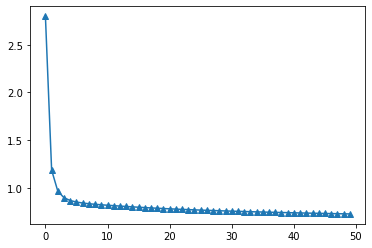

In [ ]:
# FunkSVD gradient curve
plt.plot(loss_history, "-^")

In [ ]:
# evaluation
final_result = model.evaluate(test_input, test_output) # final RMSE score
final_result

0.8903023719729586

-----

## Regularized Matrix Factorization

$\operatorname{argmin} \frac{1}{|K|} \sum_{(i, j) \in K} \left(m_{i j}-q_{j}^{T} p_{i}\right)^{2}+\lambda\left(\left\|p_{i}\right\|_{2}^{2}+\left\|q_{j}\right\|_{2}^{2}\right)$

In [ ]:
class RegMF(object):
	def __init__(self, n_user, n_item, latent_dim, lr, lamb):
		super(RegMF, self).__init__()
		self.lr = lr
		self.lamb = lamb
		U_init = np.random.normal(0, 1, size=(n_user, latent_dim)) # user embedding
		V_init = np.random.normal(0, 1, size=(latent_dim, n_item)) # itme embedding
		# initialization
		self.U, self.V = np.copy(U_init), np.copy(V_init)

	def forward(self, U, V, interaction):
		predictions = (U @ V)[interaction[:,0], interaction[:,1]]
		return predictions
	
	@partial(jit, static_argnums=(0,))
	def loss_fn(self, U, V, input_ids, output_labels):
		# defaultly, MSE loss
		# predictions = (U @ V)[input_ids[:,0], input_ids[:,1]]
		predictions = self.forward(U, V, input_ids)
		errors = output_labels - predictions

		return jnp.mean(errors**2) + self.lamb * (jnp.linalg.norm(U[input_ids[:,0]]) + jnp.linalg.norm(V[:,input_ids[:,1]]))

	def update(self, grad_u, grad_v):
		# do the gradient updates
		self.U = self.U - self.lr * grad_u
		self.V = self.V - self.lr * grad_v
	
	def evaluate(self, test_input, test_output):
		# defaultly, RMSE
		predictions = model.forward(self.U, self.V, test_input)
		return np.sqrt(np.mean((test_output - predictions)**2))

In [ ]:
# Running regularized FunkSVD
from tqdm import tqdm

model = RegMF(n_user, n_item, LATENT_DIM, LEARNING_RATE, LAMBDA)
MSE_grad_u = jax.jit(jax.grad(model.loss_fn, argnums=0))
MSE_grad_v = jax.jit(jax.grad(model.loss_fn, argnums=1))
loss_history = []

for _ in tqdm(range(INTERATION_NUM)):
    for inputs, outputs in zip(train_input_batches, train_output_batches):
        # compute the gradients
        inputs, outputs =  np.array(inputs), np.array(outputs)
        grad_u = MSE_grad_u(model.U, model.V, inputs, outputs)
        grad_v = MSE_grad_v(model.U, model.V, inputs, outputs)
        
        model.update(grad_u, grad_v)
        
    # check the loss for monitoring purposes
    training_loss = model.loss_fn(model.U, model.V, train_input, train_output)
    loss_history.append(training_loss)

100%|██████████| 50/50 [03:14<00:00,  3.89s/it]


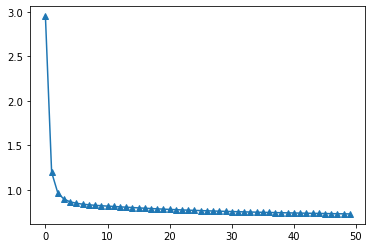

In [ ]:
# regularized FunkSVD gradient curve
plt.plot(loss_history, "-^")

In [ ]:
# evaluation
final_result = model.evaluate(test_input, test_output) # final RMSE score
final_result

0.8923480781459886

----

## BiasSVD

$\operatorname{argmin} \frac{1}{|K|} \sum_{(i, j) \in K} \left(m_{i j}-\mu-b_{Ui}-b_{Vj}-q_{j}^{T} p_{i}\right)^{2}+\lambda\left(\left\|p_{i}\right\|_{2}^{2}+\left\|q_{j}\right\|_{2}^{2}+b_{Ui}^2+b_{Vj}^2\right)$

In [ ]:
class BiasSVD(object):
	def __init__(self, n_user, n_item, latent_dim, lr, lamb, global_bias):
		super(BiasSVD, self).__init__()
		self.lr = lr
		self.lamb = lamb
		self.global_bias = global_bias
		U_init = np.random.normal(0, 1, size=(n_user, latent_dim)) # user embedding
		V_init = np.random.normal(0, 1, size=(latent_dim, n_item)) # itme embedding
		UBias_init = np.zeros(n_user) # user bias
		VBias_init = np.zeros(n_item) # item bias
		# initialization
		self.U, self.V = np.copy(U_init), np.copy(V_init)
		self.UBias, self.VBias = np.copy(UBias_init), np.copy(VBias_init)	

	def forward(self, U, V, UB, VB, interaction):
		predictions = (U @ V)[interaction[:,0], interaction[:,1]]
		return predictions + self.global_bias + UB[interaction[:, 0]] + VB[interaction[:, 1]]
	
	@partial(jit, static_argnums=(0,))
	def loss_fn(self, U, V, UB, VB, input_ids, output_labels):
		# defaultly, MSE loss
		# err = np.float32(r_ui - self.globalMean - bu[uid] - bi[iid] - np.dot(v_pu, v_qi))
		predictions = self.forward(U, V, UB, VB, input_ids)
		errors = output_labels - predictions 

		return jnp.mean(errors**2)# + self.lamb * (jnp.linalg.norm(U[input_ids[:,0]]) + jnp.linalg.norm(V[:,input_ids[:,1]]) + jnp.linalg.norm(UB[input_ids[:,1]]) + jnp.linalg.norm(VB[input_ids[:,1]]))

	def update(self, grad_u, grad_v, grad_ub, grad_vb):
		# do the gradient updates
		self.U = self.U - self.lr * grad_u
		self.V = self.V - self.lr * grad_v
		self.UBias = self.UBias - self.lr * grad_ub
		self.VBias = self.VBias - self.lr * grad_vb
	
	def evaluate(self, test_input, test_output):
		# defaultly, RMSE
		predictions = model.forward(self.U, self.V, self.UBias, self.VBias, test_input)
		return np.sqrt(np.mean((test_output - predictions)**2))

In [ ]:
# Running BiasSVD
from tqdm import tqdm

global_bias = jnp.mean(train_output)
model = BiasSVD(n_user, n_item, LATENT_DIM, LEARNING_RATE, LAMBDA, global_bias)
MSE_grad_u = jax.jit(jax.grad(model.loss_fn, argnums=0))
MSE_grad_v = jax.jit(jax.grad(model.loss_fn, argnums=1))
MSE_grad_ub = jax.jit(jax.grad(model.loss_fn, argnums=2))
MSE_grad_vb = jax.jit(jax.grad(model.loss_fn, argnums=3))
loss_history = []

for _ in tqdm(range(INTERATION_NUM)):
    for inputs, outputs in zip(train_input_batches, train_output_batches):
        # compute the gradients
        inputs, outputs =  np.array(inputs), np.array(outputs)
        grad_u = MSE_grad_u(model.U, model.V, model.UBias, model.VBias, inputs, outputs)
        grad_v = MSE_grad_v(model.U, model.V, model.UBias, model.VBias, inputs, outputs)
        grad_ub = MSE_grad_ub(model.U, model.V, model.UBias, model.VBias, inputs, outputs)
        grad_vb = MSE_grad_vb(model.U, model.V, model.UBias, model.VBias, inputs, outputs)
        
        model.update(grad_u, grad_v, grad_ub, grad_vb)
        
    # check the loss for monitoring purposes
    training_loss = model.loss_fn(model.U, model.V, model.UBias, model.VBias, train_input, train_output)
    loss_history.append(training_loss)

100%|██████████| 50/50 [03:53<00:00,  4.68s/it]


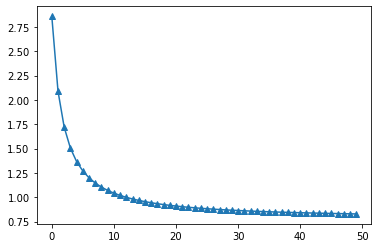

In [ ]:
# BiasSVD gradient curve
plt.plot(loss_history, "-^")

In [ ]:
# evaluation
final_result = model.evaluate(test_input, test_output) # final RMSE score
final_result

0.9362740241925629



---



---



## SVD++

$\operatorname{argmin} \frac{1}{|K|} \sum_{(i, j) \in K} \left(m_{i j}-\mu-b_{Ui}-b_{Vj}-q_{j}^{T}\left(p_{i}+\frac{\sum_{s \in I(i)} y_{s}}{\sqrt{I(i)}}\right)\right)^{2}+\lambda\left(\left\|p_{i}\right\|_{2}^{2}+\left\|q_{j}\right\|_{2}^{2}+b_{Ui}^{2}+b_{Vj}^{2}+\sum_{s \in I(i)} \left\|y_{s}\right\|^2\right.)$

In [ ]:
class SVDPP(object):
	def __init__(self, n_user, n_item, latent_dim, lr, lamb, global_bias, W):
		super(SVDPP, self).__init__()
	
		self.lr = lr
		self.lamb = lamb
		self.global_bias = global_bias
		self.W = W
		weights = 1. / np.sqrt(np.sum(W, axis=1))
		self.weighted_W = np.multiply(W, weights[:, np.newaxis])
		U_init = np.random.normal(0, 1, size=(n_user, latent_dim)) # user embedding
		V_init = np.random.normal(0, 1, size=(latent_dim, n_item)) # itme embedding
		UBias_init = np.zeros(n_user) # user bias
		VBias_init = np.zeros(n_item) # item bias
		Y_init = np.random.normal(0, 1, size=(n_item, latent_dim)) # implicit feedback
		# initialization
		self.U, self.V = np.copy(U_init), np.copy(V_init)
		self.UBias, self.VBias = np.copy(UBias_init), np.copy(VBias_init)
		self.Y = np.copy(Y_init)

	def forward(self, U, V, UB, VB, Y, interaction):
		predictions = ((U + self.weighted_W @ Y) @ V)[interaction[:,0], interaction[:,1]]
		return predictions + self.global_bias + UB[interaction[:, 0]] + VB[interaction[:, 1]]
	
	@partial(jit, static_argnums=(0,))
	def loss_fn(self, U, V, UB, VB, Y, input_ids, output_labels):
		# defaultly, MSE loss
		# err = np.float32(r_ui - self.globalMean - bu[uid] - bi[iid] - np.dot(v_pu, v_qi))
		predictions = self.forward(U, V, UB, VB, Y, input_ids)
		errors = output_labels - predictions 

		return jnp.mean(errors**2)# + self.lamb * (jnp.linalg.norm(U[input_ids[:,0]]) + jnp.linalg.norm(V[:,input_ids[:,1]]) + jnp.linalg.norm(UB[input_ids[:,1]]) + jnp.linalg.norm(VB[input_ids[:,1]]) + jnp.sum(self.W @ (Y**2)))

	def update(self, grad_u, grad_v, grad_ub, grad_vb, grad_y):
		# do the gradient updates
		self.U = self.U - self.lr * grad_u
		self.V = self.V - self.lr * grad_v
		self.UBias = self.UBias - self.lr * grad_ub
		self.VBias = self.VBias - self.lr * grad_vb
		self.Y = self.Y - self.lr * grad_y
	
	def evaluate(self, test_input, test_output):
		# defaultly, RMSE
		predictions = model.forward(self.U, self.V, self.UBias, self.VBias, self.Y, test_input)
		return np.sqrt(np.mean((test_output - predictions)**2))

In [ ]:
# Running SVD++
from tqdm import tqdm

global_bias = jnp.mean(train_output)
W = np.array(~np.isnan(R)).astype(int)

model = SVDPP(n_user, n_item, LATENT_DIM, LEARNING_RATE, LAMBDA, global_bias, W)
MSE_grad_u = jax.jit(jax.grad(model.loss_fn, argnums=0))
MSE_grad_v = jax.jit(jax.grad(model.loss_fn, argnums=1))
MSE_grad_ub = jax.jit(jax.grad(model.loss_fn, argnums=2))
MSE_grad_vb = jax.jit(jax.grad(model.loss_fn, argnums=3))
MSE_grad_y = jax.jit(jax.grad(model.loss_fn, argnums=4))
loss_history = []

for _ in tqdm(range(INTERATION_NUM)):
    loss_history_batch = []
    for inputs, outputs in zip(train_input_batches, train_output_batches):
        # compute the gradients
        inputs, outputs =  np.array(inputs), np.array(outputs)
        grad_u = MSE_grad_u(model.U, model.V, model.UBias, model.VBias, model.Y, inputs, outputs)
        grad_v = MSE_grad_v(model.U, model.V, model.UBias, model.VBias, model.Y, inputs, outputs)
        grad_ub = MSE_grad_ub(model.U, model.V, model.UBias, model.VBias, model.Y, inputs, outputs)
        grad_vb = MSE_grad_vb(model.U, model.V, model.UBias, model.VBias, model.Y, inputs, outputs)
        grad_y = MSE_grad_y(model.U, model.V, model.UBias, model.VBias, model.Y, inputs, outputs)
        
        model.update(grad_u, grad_v, grad_ub, grad_vb, grad_y)

        loss_batch = model.loss_fn(model.U, model.V, model.UBias, model.VBias, model.Y, inputs, outputs)
        loss_history_batch.append(loss_batch)

    print(loss_history_batch)
        
    # check the loss for monitoring purposes
    training_loss = model.loss_fn(model.U, model.V, model.UBias, model.VBias, model.Y, train_input, train_output)
    loss_history.append(training_loss)

  0%|          | 0/50 [00:00<?, ?it/s]

[DeviceArray(8.47051166, dtype=float64), DeviceArray(8.01138461, dtype=float64), DeviceArray(8.30593062, dtype=float64), DeviceArray(8.54211616, dtype=float64), DeviceArray(7.91694965, dtype=float64), DeviceArray(7.91064496, dtype=float64), DeviceArray(7.56577956, dtype=float64), DeviceArray(7.36287981, dtype=float64), DeviceArray(7.07879228, dtype=float64), DeviceArray(7.17801373, dtype=float64), DeviceArray(7.47157144, dtype=float64), DeviceArray(7.14788091, dtype=float64), DeviceArray(7.22673458, dtype=float64), DeviceArray(7.06394833, dtype=float64), DeviceArray(7.31953474, dtype=float64), DeviceArray(7.15872912, dtype=float64), DeviceArray(6.69222745, dtype=float64), DeviceArray(6.80926172, dtype=float64), DeviceArray(6.82879313, dtype=float64), DeviceArray(6.81040391, dtype=float64), DeviceArray(6.71438279, dtype=float64), DeviceArray(6.66318262, dtype=float64), DeviceArray(6.39642454, dtype=float64), DeviceArray(6.56697024, dtype=float64), DeviceArray(6.52712781, dtype=float64),

  4%|▍         | 2/50 [01:20<28:32, 35.67s/it]

[DeviceArray(3.0393271, dtype=float64), DeviceArray(2.94247822, dtype=float64), DeviceArray(3.13298439, dtype=float64), DeviceArray(3.20413898, dtype=float64), DeviceArray(2.96502117, dtype=float64), DeviceArray(3.07314619, dtype=float64), DeviceArray(2.85282323, dtype=float64), DeviceArray(2.88793414, dtype=float64), DeviceArray(2.85783026, dtype=float64), DeviceArray(2.85710051, dtype=float64), DeviceArray(2.95895097, dtype=float64), DeviceArray(2.90393628, dtype=float64), DeviceArray(2.97362018, dtype=float64), DeviceArray(2.83460954, dtype=float64), DeviceArray(2.9583592, dtype=float64), DeviceArray(2.94522951, dtype=float64), DeviceArray(2.85832783, dtype=float64), DeviceArray(2.88400185, dtype=float64), DeviceArray(2.89342438, dtype=float64), DeviceArray(2.88176331, dtype=float64), DeviceArray(2.81911949, dtype=float64), DeviceArray(2.89062405, dtype=float64), DeviceArray(2.69264541, dtype=float64), DeviceArray(2.81825655, dtype=float64), DeviceArray(2.8447997, dtype=float64), De

  6%|▌         | 3/50 [01:35<20:27, 26.11s/it]

[DeviceArray(2.0804192, dtype=float64), DeviceArray(2.02295946, dtype=float64), DeviceArray(2.17029252, dtype=float64), DeviceArray(2.18600653, dtype=float64), DeviceArray(2.03538981, dtype=float64), DeviceArray(2.10250076, dtype=float64), DeviceArray(1.94293038, dtype=float64), DeviceArray(1.99399393, dtype=float64), DeviceArray(2.00625333, dtype=float64), DeviceArray(1.98706047, dtype=float64), DeviceArray(2.05189073, dtype=float64), DeviceArray(2.02536011, dtype=float64), DeviceArray(2.08119663, dtype=float64), DeviceArray(1.96612083, dtype=float64), DeviceArray(2.03427667, dtype=float64), DeviceArray(2.04287269, dtype=float64), DeviceArray(2.04079057, dtype=float64), DeviceArray(2.01703969, dtype=float64), DeviceArray(2.03623066, dtype=float64), DeviceArray(2.00866539, dtype=float64), DeviceArray(1.95414263, dtype=float64), DeviceArray(2.04695774, dtype=float64), DeviceArray(1.90229398, dtype=float64), DeviceArray(1.99284079, dtype=float64), DeviceArray(2.01020755, dtype=float64), 

  8%|▊         | 4/50 [01:49<16:34, 21.62s/it]

[DeviceArray(1.68032692, dtype=float64), DeviceArray(1.63833665, dtype=float64), DeviceArray(1.76038478, dtype=float64), DeviceArray(1.76014754, dtype=float64), DeviceArray(1.64869861, dtype=float64), DeviceArray(1.69298894, dtype=float64), DeviceArray(1.56763569, dtype=float64), DeviceArray(1.61656065, dtype=float64), DeviceArray(1.64543576, dtype=float64), DeviceArray(1.61807398, dtype=float64), DeviceArray(1.67143793, dtype=float64), DeviceArray(1.65072742, dtype=float64), DeviceArray(1.69918059, dtype=float64), DeviceArray(1.60088897, dtype=float64), DeviceArray(1.64206215, dtype=float64), DeviceArray(1.65196931, dtype=float64), DeviceArray(1.68343164, dtype=float64), DeviceArray(1.64357378, dtype=float64), DeviceArray(1.66685956, dtype=float64), DeviceArray(1.62953769, dtype=float64), DeviceArray(1.58329389, dtype=float64), DeviceArray(1.68069685, dtype=float64), DeviceArray(1.56325385, dtype=float64), DeviceArray(1.6371568, dtype=float64), DeviceArray(1.6462929, dtype=float64), D

 10%|█         | 5/50 [02:04<14:20, 19.13s/it]

[DeviceArray(1.46456939, dtype=float64), DeviceArray(1.42843346, dtype=float64), DeviceArray(1.53438925, dtype=float64), DeviceArray(1.52893828, dtype=float64), DeviceArray(1.43885064, dtype=float64), DeviceArray(1.46999875, dtype=float64), DeviceArray(1.36660972, dtype=float64), DeviceArray(1.41046667, dtype=float64), DeviceArray(1.44745538, dtype=float64), DeviceArray(1.41550489, dtype=float64), DeviceArray(1.46437045, dtype=float64), DeviceArray(1.44492825, dtype=float64), DeviceArray(1.48843765, dtype=float64), DeviceArray(1.40200456, dtype=float64), DeviceArray(1.42838662, dtype=float64), DeviceArray(1.43553132, dtype=float64), DeviceArray(1.48266705, dtype=float64), DeviceArray(1.43872933, dtype=float64), DeviceArray(1.4627507, dtype=float64), DeviceArray(1.41977921, dtype=float64), DeviceArray(1.38127949, dtype=float64), DeviceArray(1.47721406, dtype=float64), DeviceArray(1.37654867, dtype=float64), DeviceArray(1.44038886, dtype=float64), DeviceArray(1.44482043, dtype=float64), 

 12%|█▏        | 6/50 [02:19<12:55, 17.63s/it]

[DeviceArray(1.33085916, dtype=float64), DeviceArray(1.2966404, dtype=float64), DeviceArray(1.39166113, dtype=float64), DeviceArray(1.38462902, dtype=float64), DeviceArray(1.30774076, dtype=float64), DeviceArray(1.33091471, dtype=float64), DeviceArray(1.24269513, dtype=float64), DeviceArray(1.28139989, dtype=float64), DeviceArray(1.3225909, dtype=float64), DeviceArray(1.28796351, dtype=float64), DeviceArray(1.33468988, dtype=float64), DeviceArray(1.31533199, dtype=float64), DeviceArray(1.35512801, dtype=float64), DeviceArray(1.27744662, dtype=float64), DeviceArray(1.29519628, dtype=float64), DeviceArray(1.29896988, dtype=float64), DeviceArray(1.35395359, dtype=float64), DeviceArray(1.31047906, dtype=float64), DeviceArray(1.33377225, dtype=float64), DeviceArray(1.28755283, dtype=float64), DeviceArray(1.2558137, dtype=float64), DeviceArray(1.34800733, dtype=float64), DeviceArray(1.25892443, dtype=float64), DeviceArray(1.3158883, dtype=float64), DeviceArray(1.31774052, dtype=float64), Dev

 14%|█▍        | 7/50 [02:33<11:57, 16.68s/it]

[DeviceArray(1.24030148, dtype=float64), DeviceArray(1.20640726, dtype=float64), DeviceArray(1.29356448, dtype=float64), DeviceArray(1.28634854, dtype=float64), DeviceArray(1.21830549, dtype=float64), DeviceArray(1.23645377, dtype=float64), DeviceArray(1.15924392, dtype=float64), DeviceArray(1.19336102, dtype=float64), DeviceArray(1.23661275, dtype=float64), DeviceArray(1.20050864, dtype=float64), DeviceArray(1.24603052, dtype=float64), DeviceArray(1.22637827, dtype=float64), DeviceArray(1.26323573, dtype=float64), DeviceArray(1.19226493, dtype=float64), DeviceArray(1.20482989, dtype=float64), DeviceArray(1.20542914, dtype=float64), DeviceArray(1.26439663, dtype=float64), DeviceArray(1.2230833, dtype=float64), DeviceArray(1.24510699, dtype=float64), DeviceArray(1.19704238, dtype=float64), DeviceArray(1.17105474, dtype=float64), DeviceArray(1.25875903, dtype=float64), DeviceArray(1.17823858, dtype=float64), DeviceArray(1.23019756, dtype=float64), DeviceArray(1.23061373, dtype=float64), 

 16%|█▌        | 8/50 [02:48<11:14, 16.06s/it]

[DeviceArray(1.17505224, dtype=float64), DeviceArray(1.14089646, dtype=float64), DeviceArray(1.22211771, dtype=float64), DeviceArray(1.21527781, dtype=float64), DeviceArray(1.15351129, dtype=float64), DeviceArray(1.16841038, dtype=float64), DeviceArray(1.09950298, dtype=float64), DeviceArray(1.12969084, dtype=float64), DeviceArray(1.17371961, dtype=float64), DeviceArray(1.13693547, dtype=float64), DeviceArray(1.18167462, dtype=float64), DeviceArray(1.16158425, dtype=float64), DeviceArray(1.19605082, dtype=float64), DeviceArray(1.1303839, dtype=float64), DeviceArray(1.13982558, dtype=float64), DeviceArray(1.13760853, dtype=float64), DeviceArray(1.1985015, dtype=float64), DeviceArray(1.15989737, dtype=float64), DeviceArray(1.18052226, dtype=float64), DeviceArray(1.13145176, dtype=float64), DeviceArray(1.11032367, dtype=float64), DeviceArray(1.19343168, dtype=float64), DeviceArray(1.11953365, dtype=float64), DeviceArray(1.16770409, dtype=float64), DeviceArray(1.16730044, dtype=float64), D

 18%|█▊        | 9/50 [03:03<10:41, 15.64s/it]

[DeviceArray(1.12584536, dtype=float64), DeviceArray(1.09127906, dtype=float64), DeviceArray(1.16783178, dtype=float64), DeviceArray(1.16157567, dtype=float64), DeviceArray(1.10446077, dtype=float64), DeviceArray(1.11722607, dtype=float64), DeviceArray(1.05478229, dtype=float64), DeviceArray(1.08163875, dtype=float64), DeviceArray(1.12564051, dtype=float64), DeviceArray(1.0887153, dtype=float64), DeviceArray(1.13288399, dtype=float64), DeviceArray(1.11229699, dtype=float64), DeviceArray(1.14478218, dtype=float64), DeviceArray(1.0834088, dtype=float64), DeviceArray(1.09101509, dtype=float64), DeviceArray(1.08633583, dtype=float64), DeviceArray(1.14800163, dtype=float64), DeviceArray(1.11217472, dtype=float64), DeviceArray(1.13144841, dtype=float64), DeviceArray(1.08188689, dtype=float64), DeviceArray(1.06486944, dtype=float64), DeviceArray(1.1435447, dtype=float64), DeviceArray(1.07493832, dtype=float64), DeviceArray(1.12015585, dtype=float64), DeviceArray(1.11927361, dtype=float64), De

 20%|██        | 10/50 [03:18<10:14, 15.36s/it]

[DeviceArray(1.08742004, dtype=float64), DeviceArray(1.05247907, dtype=float64), DeviceArray(1.1252326, dtype=float64), DeviceArray(1.11960992, dtype=float64), DeviceArray(1.06606481, dtype=float64), DeviceArray(1.07741888, dtype=float64), DeviceArray(1.02014811, dtype=float64), DeviceArray(1.04417512, dtype=float64), DeviceArray(1.08763803, dtype=float64), DeviceArray(1.05093802, dtype=float64), DeviceArray(1.09465275, dtype=float64), DeviceArray(1.0735497, dtype=float64), DeviceArray(1.10436938, dtype=float64), DeviceArray(1.04653882, dtype=float64), DeviceArray(1.05313844, dtype=float64), DeviceArray(1.04630845, dtype=float64), DeviceArray(1.10808127, dtype=float64), DeviceArray(1.07490098, dtype=float64), DeviceArray(1.09294109, dtype=float64), DeviceArray(1.04321091, dtype=float64), DeviceArray(1.02968628, dtype=float64), DeviceArray(1.10419918, dtype=float64), DeviceArray(1.03992849, dtype=float64), DeviceArray(1.08278791, dtype=float64), DeviceArray(1.08162191, dtype=float64), D

 22%|██▏       | 11/50 [03:32<09:51, 15.17s/it]

[DeviceArray(1.0565795, dtype=float64), DeviceArray(1.02137007, dtype=float64), DeviceArray(1.09094419, dtype=float64), DeviceArray(1.08593223, dtype=float64), DeviceArray(1.03520738, dtype=float64), DeviceArray(1.04562984, dtype=float64), DeviceArray(0.99260121, dtype=float64), DeviceArray(1.01420731, dtype=float64), DeviceArray(1.05680699, dtype=float64), DeviceArray(1.02058013, dtype=float64), DeviceArray(1.06390909, dtype=float64), DeviceArray(1.04229219, dtype=float64), DeviceArray(1.07169501, dtype=float64), DeviceArray(1.01683386, dtype=float64), DeviceArray(1.02297021, dtype=float64), DeviceArray(1.01425451, dtype=float64), DeviceArray(1.07574449, dtype=float64), DeviceArray(1.04500488, dtype=float64), DeviceArray(1.06195026, dtype=float64), DeviceArray(1.01225628, dtype=float64), DeviceArray(1.0017168, dtype=float64), DeviceArray(1.07237034, dtype=float64), DeviceArray(1.01172411, dtype=float64), DeviceArray(1.05266051, dtype=float64), DeviceArray(1.05132478, dtype=float64), D

 24%|██▍       | 12/50 [03:47<09:31, 15.03s/it]

[DeviceArray(1.03127408, dtype=float64), DeviceArray(0.99592084, dtype=float64), DeviceArray(1.0627732, dtype=float64), DeviceArray(1.05831752, dtype=float64), DeviceArray(1.00987631, dtype=float64), DeviceArray(1.01969182, dtype=float64), DeviceArray(0.97021757, dtype=float64), DeviceArray(0.98973139, dtype=float64), DeviceArray(1.03126744, dtype=float64), DeviceArray(0.99567956, dtype=float64), DeviceArray(1.03866459, dtype=float64), DeviceArray(1.01654918, dtype=float64), DeviceArray(1.04473384, dtype=float64), DeviceArray(0.99239418, dtype=float64), DeviceArray(0.99842723, dtype=float64), DeviceArray(0.98804958, dtype=float64), DeviceArray(1.04902964, dtype=float64), DeviceArray(1.02050471, dtype=float64), DeviceArray(1.03649329, dtype=float64), DeviceArray(0.98696708, dtype=float64), DeviceArray(0.97899469, dtype=float64), DeviceArray(1.0460906, dtype=float64), DeviceArray(0.98852452, dtype=float64), DeviceArray(1.02786383, dtype=float64), DeviceArray(1.02642591, dtype=float64), D

 26%|██▌       | 13/50 [04:02<09:12, 14.94s/it]

[DeviceArray(1.01013115, dtype=float64), DeviceArray(0.97475424, dtype=float64), DeviceArray(1.03923375, dtype=float64), DeviceArray(1.0352682, dtype=float64), DeviceArray(0.98871539, dtype=float64), DeviceArray(0.99814734, dtype=float64), DeviceArray(0.95170804, dtype=float64), DeviceArray(0.96939322, dtype=float64), DeviceArray(1.00974877, dtype=float64), DeviceArray(0.97490819, dtype=float64), DeviceArray(1.01757593, dtype=float64), DeviceArray(0.9949855, dtype=float64), DeviceArray(1.02211267, dtype=float64), DeviceArray(0.97193816, dtype=float64), DeviceArray(0.9781068, dtype=float64), DeviceArray(0.96625638, dtype=float64), DeviceArray(1.02659845, dtype=float64), DeviceArray(1.00006683, dtype=float64), DeviceArray(1.01522599, dtype=float64), DeviceArray(0.96595262, dtype=float64), DeviceArray(0.96020132, dtype=float64), DeviceArray(1.0240252, dtype=float64), DeviceArray(0.96911265, dtype=float64), DeviceArray(1.00710445, dtype=float64), DeviceArray(1.00560413, dtype=float64), Dev

 28%|██▊       | 14/50 [04:17<08:55, 14.87s/it]

[DeviceArray(0.99219778, dtype=float64), DeviceArray(0.95690358, dtype=float64), DeviceArray(1.019284, dtype=float64), DeviceArray(1.01574063, dtype=float64), DeviceArray(0.97077774, dtype=float64), DeviceArray(0.97998199, dtype=float64), DeviceArray(0.93617712, dtype=float64), DeviceArray(0.95224585, dtype=float64), DeviceArray(0.99136086, dtype=float64), DeviceArray(0.95733523, dtype=float64), DeviceArray(0.99970329, dtype=float64), DeviceArray(0.97666619, dtype=float64), DeviceArray(1.00286699, dtype=float64), DeviceArray(0.95456984, dtype=float64), DeviceArray(0.96103151, dtype=float64), DeviceArray(0.94786904, dtype=float64), DeviceArray(1.00750651, dtype=float64), DeviceArray(0.98276193, dtype=float64), DeviceArray(0.99720498, dtype=float64), DeviceArray(0.94823957, dtype=float64), DeviceArray(0.94442132, dtype=float64), DeviceArray(1.00523676, dtype=float64), DeviceArray(0.95263647, dtype=float64), DeviceArray(0.98947587, dtype=float64), DeviceArray(0.98793573, dtype=float64), D

 30%|███       | 15/50 [04:31<08:38, 14.82s/it]

[DeviceArray(0.9767921, dtype=float64), DeviceArray(0.94167038, dtype=float64), DeviceArray(1.00217204, dtype=float64), DeviceArray(0.99898601, dtype=float64), DeviceArray(0.95538241, dtype=float64), DeviceArray(0.96446909, dtype=float64), DeviceArray(0.92298368, dtype=float64), DeviceArray(0.93760779, dtype=float64), DeviceArray(0.975461, dtype=float64), DeviceArray(0.94228911, dtype=float64), DeviceArray(0.98436964, dtype=float64), DeviceArray(0.96091685, dtype=float64), DeviceArray(0.98629913, dtype=float64), DeviceArray(0.93964395, dtype=float64), DeviceArray(0.94650044, dtype=float64), DeviceArray(0.93216332, dtype=float64), DeviceArray(0.9910682, dtype=float64), DeviceArray(0.96792324, dtype=float64), DeviceArray(0.98174874, dtype=float64), DeviceArray(0.93312697, dtype=float64), DeviceArray(0.93100041, dtype=float64), DeviceArray(0.98904757, dtype=float64), DeviceArray(0.9384816, dtype=float64), DeviceArray(0.97432415, dtype=float64), DeviceArray(0.97275588, dtype=float64), Devi

 32%|███▏      | 16/50 [04:46<08:22, 14.79s/it]

[DeviceArray(0.96341342, dtype=float64), DeviceArray(0.92853745, dtype=float64), DeviceArray(0.98734175, dtype=float64), DeviceArray(0.9844535, dtype=float64), DeviceArray(0.94202726, dtype=float64), DeviceArray(0.95107504, dtype=float64), DeviceArray(0.91165677, dtype=float64), DeviceArray(0.92497662, dtype=float64), DeviceArray(0.96157311, dtype=float64), DeviceArray(0.92927316, dtype=float64), DeviceArray(0.97107504, dtype=float64), DeviceArray(0.94723859, dtype=float64), DeviceArray(0.97189159, dtype=float64), DeviceArray(0.92668379, dtype=float64), DeviceArray(0.93399851, dtype=float64), DeviceArray(0.91860498, dtype=float64), DeviceArray(0.97677366, dtype=float64), DeviceArray(0.95506025, dtype=float64), DeviceArray(0.96835278, dtype=float64), DeviceArray(0.92009758, dtype=float64), DeviceArray(0.91945913, dtype=float64), DeviceArray(0.97495541, dtype=float64), DeviceArray(0.92619386, dtype=float64), DeviceArray(0.96116577, dtype=float64), DeviceArray(0.95957402, dtype=float64), 

 34%|███▍      | 17/50 [05:01<08:06, 14.75s/it]

[DeviceArray(0.95168583, dtype=float64), DeviceArray(0.91711379, dtype=float64), DeviceArray(0.97437302, dtype=float64), DeviceArray(0.97172903, dtype=float64), DeviceArray(0.93033393, dtype=float64), DeviceArray(0.93939956, dtype=float64), DeviceArray(0.9018427, dtype=float64), DeviceArray(0.91397408, dtype=float64), DeviceArray(0.94933671, dtype=float64), DeviceArray(0.91791214, dtype=float64), DeviceArray(0.95944235, dtype=float64), DeviceArray(0.93525429, dtype=float64), DeviceArray(0.95925224, dtype=float64), DeviceArray(0.91532939, dtype=float64), DeviceArray(0.92313912, dtype=float64), DeviceArray(0.90679162, dtype=float64), DeviceArray(0.96423573, dtype=float64), DeviceArray(0.94380425, dtype=float64), DeviceArray(0.95663571, dtype=float64), DeviceArray(0.90876159, dtype=float64), DeviceArray(0.90943847, dtype=float64), DeviceArray(0.96258007, dtype=float64), DeviceArray(0.91543013, dtype=float64), DeviceArray(0.94963549, dtype=float64), DeviceArray(0.94802039, dtype=float64), 

 36%|███▌      | 18/50 [05:15<07:51, 14.73s/it]

[DeviceArray(0.94132158, dtype=float64), DeviceArray(0.90709837, dtype=float64), DeviceArray(0.9629426, dtype=float64), DeviceArray(0.96049543, dtype=float64), DeviceArray(0.92001191, dtype=float64), DeviceArray(0.9291367, dtype=float64), DeviceArray(0.89327074, dtype=float64), DeviceArray(0.9043102, dtype=float64), DeviceArray(0.93847352, dtype=float64), DeviceArray(0.9079173, dtype=float64), DeviceArray(0.94918177, dtype=float64), DeviceArray(0.92467341, dtype=float64), DeviceArray(0.94807834, dtype=float64), DeviceArray(0.90530376, dtype=float64), DeviceArray(0.91362669, dtype=float64), DeviceArray(0.89641459, dtype=float64), DeviceArray(0.9531551, dtype=float64), DeviceArray(0.9338728, dtype=float64), DeviceArray(0.94630397, dtype=float64), DeviceArray(0.89881983, dtype=float64), DeviceArray(0.90066449, dtype=float64), DeviceArray(0.95162831, dtype=float64), DeviceArray(0.90592636, dtype=float64), DeviceArray(0.9394522, dtype=float64), DeviceArray(0.93781104, dtype=float64), Device

 38%|███▊      | 19/50 [05:30<07:36, 14.72s/it]

[DeviceArray(0.93209659, dtype=float64), DeviceArray(0.89825577, dtype=float64), DeviceArray(0.95279771, dtype=float64), DeviceArray(0.95050567, dtype=float64), DeviceArray(0.91083448, dtype=float64), DeviceArray(0.92004871, dtype=float64), DeviceArray(0.88573018, dtype=float64), DeviceArray(0.89575915, dtype=float64), DeviceArray(0.92876519, dtype=float64), DeviceArray(0.89906276, dtype=float64), DeviceArray(0.94006693, dtype=float64), DeviceArray(0.91526843, dtype=float64), DeviceArray(0.93813238, dtype=float64), DeviceArray(0.89639014, dtype=float64), DeviceArray(0.90523157, dtype=float64), DeviceArray(0.88723332, dtype=float64), DeviceArray(0.94329667, dtype=float64), DeviceArray(0.92504593, dtype=float64), DeviceArray(0.93712796, dtype=float64), DeviceArray(0.89003896, dtype=float64), DeviceArray(0.89292466, dtype=float64), DeviceArray(0.94187026, dtype=float64), DeviceArray(0.89747599, dtype=float64), DeviceArray(0.93039601, dtype=float64), DeviceArray(0.92872436, dtype=float64),

 40%|████      | 20/50 [05:45<07:21, 14.71s/it]

[DeviceArray(0.92383375, dtype=float64), DeviceArray(0.89039928, dtype=float64), DeviceArray(0.94373783, dtype=float64), DeviceArray(0.94156449, dtype=float64), DeviceArray(0.9026221, dtype=float64), DeviceArray(0.91194809, dtype=float64), DeviceArray(0.87905461, dtype=float64), DeviceArray(0.88814252, dtype=float64), DeviceArray(0.92003775, dtype=float64), DeviceArray(0.89116935, dtype=float64), DeviceArray(0.93191846, dtype=float64), DeviceArray(0.90685856, dtype=float64), DeviceArray(0.92922532, dtype=float64), DeviceArray(0.88841642, dtype=float64), DeviceArray(0.89777274, dtype=float64), DeviceArray(0.87905761, dtype=float64), DeviceArray(0.93447316, dtype=float64), DeviceArray(0.91714977, dtype=float64), DeviceArray(0.92892564, dtype=float64), DeviceArray(0.88223437, dtype=float64), DeviceArray(0.88605163, dtype=float64), DeviceArray(0.93312313, dtype=float64), DeviceArray(0.8899151, dtype=float64), DeviceArray(0.92229234, dtype=float64), DeviceArray(0.92058482, dtype=float64), D

 42%|████▏     | 21/50 [05:59<07:06, 14.70s/it]

[DeviceArray(0.91639113, dtype=float64), DeviceArray(0.88337899, dtype=float64), DeviceArray(0.93560183, dtype=float64), DeviceArray(0.93351547, dtype=float64), DeviceArray(0.89523079, dtype=float64), DeviceArray(0.90468503, dtype=float64), DeviceArray(0.87311089, dtype=float64), DeviceArray(0.88131759, dtype=float64), DeviceArray(0.91215086, dtype=float64), DeviceArray(0.88409308, dtype=float64), DeviceArray(0.92459241, dtype=float64), DeviceArray(0.89929824, dtype=float64), DeviceArray(0.92120478, dtype=float64), DeviceArray(0.88124412, dtype=float64), DeviceArray(0.89110565, dtype=float64), DeviceArray(0.87173518, dtype=float64), DeviceArray(0.92653352, dtype=float64), DeviceArray(0.9100451, dtype=float64), DeviceArray(0.92155085, dtype=float64), DeviceArray(0.87525814, dtype=float64), DeviceArray(0.8799119, dtype=float64), DeviceArray(0.92523964, dtype=float64), DeviceArray(0.88311193, dtype=float64), DeviceArray(0.9150008, dtype=float64), DeviceArray(0.91325164, dtype=float64), De

 44%|████▍     | 22/50 [06:14<06:51, 14.70s/it]

[DeviceArray(0.90965364, dtype=float64), DeviceArray(0.87707322, dtype=float64), DeviceArray(0.9282588, dtype=float64), DeviceArray(0.92623185, dtype=float64), DeviceArray(0.8885437, dtype=float64), DeviceArray(0.89813838, dtype=float64), DeviceArray(0.86779129, dtype=float64), DeviceArray(0.87516891, dtype=float64), DeviceArray(0.90498992, dtype=float64), DeviceArray(0.87771694, dtype=float64), DeviceArray(0.91797189, dtype=float64), DeviceArray(0.89246894, dtype=float64), DeviceArray(0.91394659, dtype=float64), DeviceArray(0.87476058, dtype=float64), DeviceArray(0.88511354, dtype=float64), DeviceArray(0.86514271, dtype=float64), DeviceArray(0.91935453, dtype=float64), DeviceArray(0.90361906, dtype=float64), DeviceArray(0.91488495, dtype=float64), DeviceArray(0.86899038, dtype=float64), DeviceArray(0.87439767, dtype=float64), DeviceArray(0.9180998, dtype=float64), DeviceArray(0.87695935, dtype=float64), DeviceArray(0.90840716, dtype=float64), DeviceArray(0.90661057, dtype=float64), De

 46%|████▌     | 23/50 [06:29<06:36, 14.70s/it]

[DeviceArray(0.90352689, dtype=float64), DeviceArray(0.8713822, dtype=float64), DeviceArray(0.92160122, dtype=float64), DeviceArray(0.9196098, dtype=float64), DeviceArray(0.88246505, dtype=float64), DeviceArray(0.89220913, dtype=float64), DeviceArray(0.86300771, dtype=float64), DeviceArray(0.86960209, dtype=float64), DeviceArray(0.8984604, dtype=float64), DeviceArray(0.87194488, dtype=float64), DeviceArray(0.91196102, dtype=float64), DeviceArray(0.88627314, dtype=float64), DeviceArray(0.90734849, dtype=float64), DeviceArray(0.86887312, dtype=float64), DeviceArray(0.87970114, dtype=float64), DeviceArray(0.8591793, dtype=float64), DeviceArray(0.9128347, dtype=float64), DeviceArray(0.89777924, dtype=float64), DeviceArray(0.90883066, dtype=float64), DeviceArray(0.86333293, dtype=float64), DeviceArray(0.86942097, dtype=float64), DeviceArray(0.91160478, dtype=float64), DeviceArray(0.87136937, dtype=float64), DeviceArray(0.90241749, dtype=float64), DeviceArray(0.90056792, dtype=float64), Devi

 48%|████▊     | 24/50 [06:43<06:22, 14.70s/it]

[DeviceArray(0.89793274, dtype=float64), DeviceArray(0.8662234, dtype=float64), DeviceArray(0.91554, dtype=float64), DeviceArray(0.91356339, dtype=float64), DeviceArray(0.87691559, dtype=float64), DeviceArray(0.88681557, dtype=float64), DeviceArray(0.85868744, dtype=float64), DeviceArray(0.86453928, dtype=float64), DeviceArray(0.89248358, dtype=float64), DeviceArray(0.86669732, dtype=float64), DeviceArray(0.9064804, dtype=float64), DeviceArray(0.88062981, dtype=float64), DeviceArray(0.90132554, dtype=float64), DeviceArray(0.86350481, dtype=float64), DeviceArray(0.87478991, dtype=float64), DeviceArray(0.85376159, dtype=float64), DeviceArray(0.90688964, dtype=float64), DeviceArray(0.89244921, dtype=float64), DeviceArray(0.90330753, dtype=float64), DeviceArray(0.85820466, dtype=float64), DeviceArray(0.86490932, dtype=float64), DeviceArray(0.90567247, dtype=float64), DeviceArray(0.86626902, dtype=float64), DeviceArray(0.89695386, dtype=float64), DeviceArray(0.89504615, dtype=float64), Devi

 50%|█████     | 25/50 [06:58<06:07, 14.69s/it]

[DeviceArray(0.89280588, dtype=float64), DeviceArray(0.86152799, dtype=float64), DeviceArray(0.91000065, dtype=float64), DeviceArray(0.90802096, dtype=float64), DeviceArray(0.87182916, dtype=float64), DeviceArray(0.88188965, dtype=float64), DeviceArray(0.85477001, dtype=float64), DeviceArray(0.85991568, dtype=float64), DeviceArray(0.88699333, dtype=float64), DeviceArray(0.86190776, dtype=float64), DeviceArray(0.90146372, dtype=float64), DeviceArray(0.87547109, dtype=float64), DeviceArray(0.89580657, dtype=float64), DeviceArray(0.85859127, dtype=float64), DeviceArray(0.8703146, dtype=float64), DeviceArray(0.84882015, dtype=float64), DeviceArray(0.9014486, dtype=float64), DeviceArray(0.88756521, dtype=float64), DeviceArray(0.89824845, dtype=float64), DeviceArray(0.85353792, dtype=float64), DeviceArray(0.86080247, dtype=float64), DeviceArray(0.90023402, dtype=float64), DeviceArray(0.8615973, dtype=float64), DeviceArray(0.89195098, dtype=float64), DeviceArray(0.88998049, dtype=float64), De

 52%|█████▏    | 26/50 [07:13<05:52, 14.69s/it]

[DeviceArray(0.88809129, dtype=float64), DeviceArray(0.85723813, dtype=float64), DeviceArray(0.90492044, dtype=float64), DeviceArray(0.90292218, dtype=float64), DeviceArray(0.86715015, dtype=float64), DeviceArray(0.87737427, dtype=float64), DeviceArray(0.85120467, dtype=float64), DeviceArray(0.85567695, dtype=float64), DeviceArray(0.88193368, dtype=float64), DeviceArray(0.85752022, dtype=float64), DeviceArray(0.89685517, dtype=float64), DeviceArray(0.87073968, dtype=float64), DeviceArray(0.89073153, dtype=float64), DeviceArray(0.85407815, dtype=float64), DeviceArray(0.86622056, dtype=float64), DeviceArray(0.84429671, dtype=float64), DeviceArray(0.89645183, dtype=float64), DeviceArray(0.88307361, dtype=float64), DeviceArray(0.89359702, dtype=float64), DeviceArray(0.84927592, dtype=float64), DeviceArray(0.85704994, dtype=float64), DeviceArray(0.89523126, dtype=float64), DeviceArray(0.85730277, dtype=float64), DeviceArray(0.8873538, dtype=float64), DeviceArray(0.88531645, dtype=float64), 

 54%|█████▍    | 27/50 [07:27<05:37, 14.69s/it]

[DeviceArray(0.88374224, dtype=float64), DeviceArray(0.85330492, dtype=float64), DeviceArray(0.90024614, dtype=float64), DeviceArray(0.89821594, dtype=float64), DeviceArray(0.86283142, dtype=float64), DeviceArray(0.87322112, dtype=float64), DeviceArray(0.8479486, dtype=float64), DeviceArray(0.85177718, dtype=float64), DeviceArray(0.87725694, dtype=float64), DeviceArray(0.85348726, dtype=float64), DeviceArray(0.89260741, dtype=float64), DeviceArray(0.86638688, dtype=float64), DeviceArray(0.88604938, dtype=float64), DeviceArray(0.8499193, dtype=float64), DeviceArray(0.86246165, dtype=float64), DeviceArray(0.84014196, dtype=float64), DeviceArray(0.89184851, dtype=float64), DeviceArray(0.87892899, dtype=float64), DeviceArray(0.88930554, dtype=float64), DeviceArray(0.84537059, dtype=float64), DeviceArray(0.8536091, dtype=float64), DeviceArray(0.8906147, dtype=float64), DeviceArray(0.85334178, dtype=float64), DeviceArray(0.88311552, dtype=float64), DeviceArray(0.88100783, dtype=float64), Dev

 56%|█████▌    | 28/50 [07:42<05:23, 14.69s/it]

[DeviceArray(0.87971881, dtype=float64), DeviceArray(0.84968669, dtype=float64), DeviceArray(0.8959323, dtype=float64), DeviceArray(0.89385864, dtype=float64), DeviceArray(0.85883278, dtype=float64), DeviceArray(0.86938907, dtype=float64), DeviceArray(0.84496539, dtype=float64), DeviceArray(0.84817735, dtype=float64), DeviceArray(0.87292217, dtype=float64), DeviceArray(0.84976837, dtype=float64), DeviceArray(0.88868006, dtype=float64), DeviceArray(0.862371, dtype=float64), DeviceArray(0.88171648, dtype=float64), DeviceArray(0.84607524, dtype=float64), DeviceArray(0.85899868, dtype=float64), DeviceArray(0.83631394, dtype=float64), DeviceArray(0.88759515, dtype=float64), DeviceArray(0.87509259, dtype=float64), DeviceArray(0.88533336, dtype=float64), DeviceArray(0.84178101, dtype=float64), DeviceArray(0.85044371, dtype=float64), DeviceArray(0.88634192, dtype=float64), DeviceArray(0.84967705, dtype=float64), DeviceArray(0.8791961, dtype=float64), DeviceArray(0.87701517, dtype=float64), Dev

 58%|█████▊    | 29/50 [07:57<05:08, 14.69s/it]

[DeviceArray(0.87598663, dtype=float64), DeviceArray(0.8463478, dtype=float64), DeviceArray(0.89193986, dtype=float64), DeviceArray(0.88981283, dtype=float64), DeviceArray(0.85511977, dtype=float64), DeviceArray(0.86584289, dtype=float64), DeviceArray(0.84222392, dtype=float64), DeviceArray(0.84484405, dtype=float64), DeviceArray(0.86889405, dtype=float64), DeviceArray(0.84632882, dtype=float64), DeviceArray(0.88503843, dtype=float64), DeviceArray(0.85865615, dtype=float64), DeviceArray(0.87769528, dtype=float64), DeviceArray(0.84251201, dtype=float64), DeviceArray(0.85579815, dtype=float64), DeviceArray(0.83277672, dtype=float64), DeviceArray(0.88365432, dtype=float64), DeviceArray(0.87153115, dtype=float64), DeviceArray(0.8816457, dtype=float64), DeviceArray(0.83847212, dtype=float64), DeviceArray(0.84752279, dtype=float64), DeviceArray(0.8823764, dtype=float64), DeviceArray(0.8462765, dtype=float64), DeviceArray(0.87556109, dtype=float64), DeviceArray(0.8733046, dtype=float64), Devi

 60%|██████    | 30/50 [08:12<04:53, 14.69s/it]

[DeviceArray(0.87251595, dtype=float64), DeviceArray(0.84325752, dtype=float64), DeviceArray(0.88823508, dtype=float64), DeviceArray(0.88604616, dtype=float64), DeviceArray(0.85166263, dtype=float64), DeviceArray(0.86255218, dtype=float64), DeviceArray(0.83969744, dtype=float64), DeviceArray(0.84174852, dtype=float64), DeviceArray(0.86514192, dtype=float64), DeviceArray(0.8431386, dtype=float64), DeviceArray(0.88165257, dtype=float64), DeviceArray(0.85521127, dtype=float64), DeviceArray(0.87395332, dtype=float64), DeviceArray(0.83920023, dtype=float64), DeviceArray(0.85283124, dtype=float64), DeviceArray(0.82949931, dtype=float64), DeviceArray(0.87999359, dtype=float64), DeviceArray(0.86821596, dtype=float64), DeviceArray(0.87821256, dtype=float64), DeviceArray(0.83541371, dtype=float64), DeviceArray(0.84481968, dtype=float64), DeviceArray(0.87868645, dtype=float64), DeviceArray(0.84311239, dtype=float64), DeviceArray(0.87218067, dtype=float64), DeviceArray(0.86984685, dtype=float64), 

 62%|██████▏   | 31/50 [08:26<04:39, 14.70s/it]

[DeviceArray(0.86928088, dtype=float64), DeviceArray(0.84038931, dtype=float64), DeviceArray(0.88478863, dtype=float64), DeviceArray(0.88253056, dtype=float64), DeviceArray(0.84843555, dtype=float64), DeviceArray(0.85949063, dtype=float64), DeviceArray(0.83736283, dtype=float64), DeviceArray(0.83886588, dtype=float64), DeviceArray(0.86163904, dtype=float64), DeviceArray(0.84017169, dtype=float64), DeviceArray(0.87849647, dtype=float64), DeviceArray(0.85200932, dtype=float64), DeviceArray(0.87046237, dtype=float64), DeviceArray(0.83611436, dtype=float64), DeviceArray(0.85007304, dtype=float64), DeviceArray(0.82645491, dtype=float64), DeviceArray(0.87658479, dtype=float64), DeviceArray(0.86512209, dtype=float64), DeviceArray(0.87500799, dtype=float64), DeviceArray(0.83257962, dtype=float64), DeviceArray(0.84231132, dtype=float64), DeviceArray(0.87524446, dtype=float64), DeviceArray(0.84016062, dtype=float64), DeviceArray(0.86902889, dtype=float64), DeviceArray(0.86661648, dtype=float64),

 64%|██████▍   | 32/50 [08:41<04:24, 14.71s/it]

[DeviceArray(0.86625876, dtype=float64), DeviceArray(0.83772004, dtype=float64), DeviceArray(0.88157493, dtype=float64), DeviceArray(0.87924152, dtype=float64), DeviceArray(0.84541604, dtype=float64), DeviceArray(0.85663528, dtype=float64), DeviceArray(0.8352, dtype=float64), DeviceArray(0.83617448, dtype=float64), DeviceArray(0.85836198, dtype=float64), DeviceArray(0.83740541, dtype=float64), DeviceArray(0.87554744, dtype=float64), DeviceArray(0.84902666, dtype=float64), DeviceArray(0.86719779, dtype=float64), DeviceArray(0.83323207, dtype=float64), DeviceArray(0.8475019, dtype=float64), DeviceArray(0.82362017, dtype=float64), DeviceArray(0.87340325, dtype=float64), DeviceArray(0.86222781, dtype=float64), DeviceArray(0.87200939, dtype=float64), DeviceArray(0.82994708, dtype=float64), DeviceArray(0.83997765, dtype=float64), DeviceArray(0.87202625, dtype=float64), DeviceArray(0.83740011, dtype=float64), DeviceArray(0.86608305, dtype=float64), DeviceArray(0.8635913, dtype=float64), Devic

 66%|██████▌   | 33/50 [08:56<04:10, 14.71s/it]

[DeviceArray(0.86342968, dtype=float64), DeviceArray(0.83522955, dtype=float64), DeviceArray(0.87857153, dtype=float64), DeviceArray(0.87615755, dtype=float64), DeviceArray(0.84258439, dtype=float64), DeviceArray(0.85396607, dtype=float64), DeviceArray(0.83319145, dtype=float64), DeviceArray(0.83365541, dtype=float64), DeviceArray(0.8552901, dtype=float64), DeviceArray(0.83481989, dtype=float64), DeviceArray(0.87278555, dtype=float64), DeviceArray(0.84624253, dtype=float64), DeviceArray(0.86413796, dtype=float64), DeviceArray(0.83053377, dtype=float64), DeviceArray(0.84509889, dtype=float64), DeviceArray(0.82097466, dtype=float64), DeviceArray(0.87042736, dtype=float64), DeviceArray(0.85951403, dtype=float64), DeviceArray(0.86919703, dtype=float64), DeviceArray(0.8274962, dtype=float64), DeviceArray(0.83780118, dtype=float64), DeviceArray(0.86901054, dtype=float64), DeviceArray(0.83481236, dtype=float64), DeviceArray(0.86332322, dtype=float64), DeviceArray(0.8607518, dtype=float64), De

 68%|██████▊   | 34/50 [09:10<03:55, 14.72s/it]

[DeviceArray(0.86077602, dtype=float64), DeviceArray(0.83290013, dtype=float64), DeviceArray(0.87575866, dtype=float64), DeviceArray(0.87325973, dtype=float64), DeviceArray(0.83992325, dtype=float64), DeviceArray(0.85146532, dtype=float64), DeviceArray(0.83132181, dtype=float64), DeviceArray(0.83129203, dtype=float64), DeviceArray(0.85240517, dtype=float64), DeviceArray(0.83239763, dtype=float64), DeviceArray(0.8701933, dtype=float64), DeviceArray(0.84363863, dtype=float64), DeviceArray(0.86126381, dtype=float64), DeviceArray(0.82800219, dtype=float64), DeviceArray(0.84284742, dtype=float64), DeviceArray(0.81850045, dtype=float64), DeviceArray(0.86763804, dtype=float64), DeviceArray(0.85696398, dtype=float64), DeviceArray(0.86655357, dtype=float64), DeviceArray(0.8252095, dtype=float64), DeviceArray(0.83576652, dtype=float64), DeviceArray(0.86617852, dtype=float64), DeviceArray(0.83238105, dtype=float64), DeviceArray(0.86073182, dtype=float64), DeviceArray(0.8580808, dtype=float64), De

 70%|███████   | 35/50 [09:25<03:40, 14.72s/it]

[DeviceArray(0.85828219, dtype=float64), DeviceArray(0.83071619, dtype=float64), DeviceArray(0.87311884, dtype=float64), DeviceArray(0.87053132, dtype=float64), DeviceArray(0.83741729, dtype=float64), DeviceArray(0.84911744, dtype=float64), DeviceArray(0.82957759, dtype=float64), DeviceArray(0.82906971, dtype=float64), DeviceArray(0.84969102, dtype=float64), DeviceArray(0.83012322, dtype=float64), DeviceArray(0.86775517, dtype=float64), DeviceArray(0.84119873, dtype=float64), DeviceArray(0.8585585, dtype=float64), DeviceArray(0.82562204, dtype=float64), DeviceArray(0.84073286, dtype=float64), DeviceArray(0.8161817, dtype=float64), DeviceArray(0.86501841, dtype=float64), DeviceArray(0.85456281, dtype=float64), DeviceArray(0.86406372, dtype=float64), DeviceArray(0.82307157, dtype=float64), DeviceArray(0.83386014, dtype=float64), DeviceArray(0.86351349, dtype=float64), DeviceArray(0.8300917, dtype=float64), DeviceArray(0.85829327, dtype=float64), DeviceArray(0.85556307, dtype=float64), De

 72%|███████▏  | 36/50 [09:40<03:26, 14.72s/it]

[DeviceArray(0.85593429, dtype=float64), DeviceArray(0.82866395, dtype=float64), DeviceArray(0.87063652, dtype=float64), DeviceArray(0.86795745, dtype=float64), DeviceArray(0.83505293, dtype=float64), DeviceArray(0.84690859, dtype=float64), DeviceArray(0.82794683, dtype=float64), DeviceArray(0.82697545, dtype=float64), DeviceArray(0.84713325, dtype=float64), DeviceArray(0.82798296, dtype=float64), DeviceArray(0.86545738, dtype=float64), DeviceArray(0.83890841, dtype=float64), DeviceArray(0.85600705, dtype=float64), DeviceArray(0.82337974, dtype=float64), DeviceArray(0.83874224, dtype=float64), DeviceArray(0.81400439, dtype=float64), DeviceArray(0.86255348, dtype=float64), DeviceArray(0.85229731, dtype=float64), DeviceArray(0.86171394, dtype=float64), DeviceArray(0.82106878, dtype=float64), DeviceArray(0.83207004, dtype=float64), DeviceArray(0.86100056, dtype=float64), DeviceArray(0.82793145, dtype=float64), DeviceArray(0.8559937, dtype=float64), DeviceArray(0.85318509, dtype=float64), 

 74%|███████▍  | 37/50 [09:55<03:11, 14.73s/it]

[DeviceArray(0.85371987, dtype=float64), DeviceArray(0.82673118, dtype=float64), DeviceArray(0.86829787, dtype=float64), DeviceArray(0.86552488, dtype=float64), DeviceArray(0.83281803, dtype=float64), DeviceArray(0.84482646, dtype=float64), DeviceArray(0.82641894, dtype=float64), DeviceArray(0.82499772, dtype=float64), DeviceArray(0.84471898, dtype=float64), DeviceArray(0.82596465, dtype=float64), DeviceArray(0.86328767, dtype=float64), DeviceArray(0.8367548, dtype=float64), DeviceArray(0.8535961, dtype=float64), DeviceArray(0.82126315, dtype=float64), DeviceArray(0.83686405, dtype=float64), DeviceArray(0.81195605, dtype=float64), DeviceArray(0.8602299, dtype=float64), DeviceArray(0.85015574, dtype=float64), DeviceArray(0.85949222, dtype=float64), DeviceArray(0.81918902, dtype=float64), DeviceArray(0.83038557, dtype=float64), DeviceArray(0.8586264, dtype=float64), DeviceArray(0.82588879, dtype=float64), DeviceArray(0.85382074, dtype=float64), DeviceArray(0.85093475, dtype=float64), Dev

 76%|███████▌  | 38/50 [10:09<02:56, 14.73s/it]

[DeviceArray(0.85162777, dtype=float64), DeviceArray(0.82490698, dtype=float64), DeviceArray(0.86609048, dtype=float64), DeviceArray(0.86322175, dtype=float64), DeviceArray(0.83070176, dtype=float64), DeviceArray(0.84286003, dtype=float64), DeviceArray(0.82498448, dtype=float64), DeviceArray(0.8231262, dtype=float64), DeviceArray(0.84243667, dtype=float64), DeviceArray(0.82405741, dtype=float64), DeviceArray(0.86123505, dtype=float64), DeviceArray(0.83472638, dtype=float64), DeviceArray(0.85131373, dtype=float64), DeviceArray(0.81926144, dtype=float64), DeviceArray(0.835088, dtype=float64), DeviceArray(0.81002555, dtype=float64), DeviceArray(0.8580357, dtype=float64), DeviceArray(0.84812756, dtype=float64), DeviceArray(0.85738784, dtype=float64), DeviceArray(0.81742149, dtype=float64), DeviceArray(0.82879724, dtype=float64), DeviceArray(0.85637905, dtype=float64), DeviceArray(0.82395341, dtype=float64), DeviceArray(0.8517633, dtype=float64), DeviceArray(0.84880122, dtype=float64), Devi

 78%|███████▊  | 39/50 [10:24<02:42, 14.73s/it]

[DeviceArray(0.84964795, dtype=float64), DeviceArray(0.8231816, dtype=float64), DeviceArray(0.86400325, dtype=float64), DeviceArray(0.86103744, dtype=float64), DeviceArray(0.8286944, dtype=float64), DeviceArray(0.84099943, dtype=float64), DeviceArray(0.823635, dtype=float64), DeviceArray(0.82135168, dtype=float64), DeviceArray(0.84027596, dtype=float64), DeviceArray(0.82225148, dtype=float64), DeviceArray(0.85928964, dtype=float64), DeviceArray(0.83281279, dtype=float64), DeviceArray(0.8491492, dtype=float64), DeviceArray(0.81736487, dtype=float64), DeviceArray(0.83340488, dtype=float64), DeviceArray(0.80820291, dtype=float64), DeviceArray(0.85596017, dtype=float64), DeviceArray(0.8462033, dtype=float64), DeviceArray(0.85539119, dtype=float64), DeviceArray(0.81575654, dtype=float64), DeviceArray(0.82729654, dtype=float64), DeviceArray(0.85424771, dtype=float64), DeviceArray(0.82211602, dtype=float64), DeviceArray(0.84981141, dtype=float64), DeviceArray(0.84677474, dtype=float64), Devic

 80%|████████  | 40/50 [10:39<02:27, 14.73s/it]

[DeviceArray(0.84777131, dtype=float64), DeviceArray(0.82154632, dtype=float64), DeviceArray(0.86202614, dtype=float64), DeviceArray(0.85896234, dtype=float64), DeviceArray(0.82678719, dtype=float64), DeviceArray(0.83923577, dtype=float64), DeviceArray(0.82236292, dtype=float64), DeviceArray(0.81966584, dtype=float64), DeviceArray(0.8382275, dtype=float64), DeviceArray(0.82053807, dtype=float64), DeviceArray(0.85744256, dtype=float64), DeviceArray(0.8310047, dtype=float64), DeviceArray(0.84709285, dtype=float64), DeviceArray(0.81556463, dtype=float64), DeviceArray(0.8318064, dtype=float64), DeviceArray(0.80647917, dtype=float64), DeviceArray(0.85399365, dtype=float64), DeviceArray(0.84437444, dtype=float64), DeviceArray(0.85349365, dtype=float64), DeviceArray(0.81418549, dtype=float64), DeviceArray(0.82587584, dtype=float64), DeviceArray(0.85222261, dtype=float64), DeviceArray(0.82036822, dtype=float64), DeviceArray(0.84795607, dtype=float64), DeviceArray(0.84484649, dtype=float64), De

 82%|████████▏ | 41/50 [10:54<02:12, 14.73s/it]

[DeviceArray(0.84598961, dtype=float64), DeviceArray(0.81999329, dtype=float64), DeviceArray(0.86015011, dtype=float64), DeviceArray(0.85698782, dtype=float64), DeviceArray(0.82497221, dtype=float64), DeviceArray(0.83756099, dtype=float64), DeviceArray(0.8211614, dtype=float64), DeviceArray(0.81806119, dtype=float64), DeviceArray(0.83628282, dtype=float64), DeviceArray(0.81890924, dtype=float64), DeviceArray(0.85568576, dtype=float64), DeviceArray(0.82929367, dtype=float64), DeviceArray(0.84513593, dtype=float64), DeviceArray(0.81385279, dtype=float64), DeviceArray(0.83028508, dtype=float64), DeviceArray(0.80484625, dtype=float64), DeviceArray(0.85212745, dtype=float64), DeviceArray(0.84263325, dtype=float64), DeviceArray(0.85168746, dtype=float64), DeviceArray(0.81270056, dtype=float64), DeviceArray(0.82452824, dtype=float64), DeviceArray(0.85029488, dtype=float64), DeviceArray(0.81870239, dtype=float64), DeviceArray(0.84618912, dtype=float64), DeviceArray(0.84300849, dtype=float64), 

 84%|████████▍ | 42/50 [11:08<01:57, 14.73s/it]

[DeviceArray(0.84429536, dtype=float64), DeviceArray(0.8185154, dtype=float64), DeviceArray(0.85836694, dtype=float64), DeviceArray(0.855106, dtype=float64), DeviceArray(0.82324227, dtype=float64), DeviceArray(0.83596782, dtype=float64), DeviceArray(0.82002426, dtype=float64), DeviceArray(0.81653096, dtype=float64), DeviceArray(0.83443427, dtype=float64), DeviceArray(0.81735782, dtype=float64), DeviceArray(0.85401194, dtype=float64), DeviceArray(0.82767201, dtype=float64), DeviceArray(0.84327051, dtype=float64), DeviceArray(0.81222214, dtype=float64), DeviceArray(0.82883414, dtype=float64), DeviceArray(0.80329682, dtype=float64), DeviceArray(0.85035367, dtype=float64), DeviceArray(0.84097271, dtype=float64), DeviceArray(0.84996559, dtype=float64), DeviceArray(0.81129468, dtype=float64), DeviceArray(0.8232475, dtype=float64), DeviceArray(0.84845643, dtype=float64), DeviceArray(0.81711159, dtype=float64), DeviceArray(0.84450317, dtype=float64), DeviceArray(0.84125346, dtype=float64), Dev

 86%|████████▌ | 43/50 [11:23<01:43, 14.73s/it]

[DeviceArray(0.84268171, dtype=float64), DeviceArray(0.81710624, dtype=float64), DeviceArray(0.85666916, dtype=float64), DeviceArray(0.85330977, dtype=float64), DeviceArray(0.82159083, dtype=float64), DeviceArray(0.83444962, dtype=float64), DeviceArray(0.81894587, dtype=float64), DeviceArray(0.81506899, dtype=float64), DeviceArray(0.83267488, dtype=float64), DeviceArray(0.81587728, dtype=float64), DeviceArray(0.85241447, dtype=float64), DeviceArray(0.82613277, dtype=float64), DeviceArray(0.84148938, dtype=float64), DeviceArray(0.81066611, dtype=float64), DeviceArray(0.82744741, dtype=float64), DeviceArray(0.80182424, dtype=float64), DeviceArray(0.84866515, dtype=float64), DeviceArray(0.83938641, dtype=float64), DeviceArray(0.84832168, dtype=float64), DeviceArray(0.80996149, dtype=float64), DeviceArray(0.82202799, dtype=float64), DeviceArray(0.84669989, dtype=float64), DeviceArray(0.81558949, dtype=float64), DeviceArray(0.84289148, dtype=float64), DeviceArray(0.83957476, dtype=float64),

 88%|████████▊ | 44/50 [11:38<01:28, 14.73s/it]

[DeviceArray(0.84114238, dtype=float64), DeviceArray(0.81575999, dtype=float64), DeviceArray(0.85504996, dtype=float64), DeviceArray(0.85159262, dtype=float64), DeviceArray(0.82001195, dtype=float64), DeviceArray(0.83300034, dtype=float64), DeviceArray(0.81792109, dtype=float64), DeviceArray(0.81366965, dtype=float64), DeviceArray(0.83099831, dtype=float64), DeviceArray(0.81446168, dtype=float64), DeviceArray(0.8508873, dtype=float64), DeviceArray(0.82466956, dtype=float64), DeviceArray(0.83978593, dtype=float64), DeviceArray(0.80917872, dtype=float64), DeviceArray(0.82611926, dtype=float64), DeviceArray(0.80042246, dtype=float64), DeviceArray(0.84705539, dtype=float64), DeviceArray(0.83786851, dtype=float64), DeviceArray(0.84674993, dtype=float64), DeviceArray(0.80869518, dtype=float64), DeviceArray(0.82086452, dtype=float64), DeviceArray(0.84501845, dtype=float64), DeviceArray(0.81413027, dtype=float64), DeviceArray(0.84134788, dtype=float64), DeviceArray(0.83796632, dtype=float64), 

 90%|█████████ | 45/50 [11:53<01:13, 14.73s/it]

[DeviceArray(0.83967163, dtype=float64), DeviceArray(0.81447135, dtype=float64), DeviceArray(0.85350311, dtype=float64), DeviceArray(0.84994859, dtype=float64), DeviceArray(0.81850015, dtype=float64), DeviceArray(0.83161443, dtype=float64), DeviceArray(0.81694523, dtype=float64), DeviceArray(0.81232782, dtype=float64), DeviceArray(0.82939877, dtype=float64), DeviceArray(0.81310559, dtype=float64), DeviceArray(0.84942486, dtype=float64), DeviceArray(0.82327654, dtype=float64), DeviceArray(0.83815412, dtype=float64), DeviceArray(0.80775447, dtype=float64), DeviceArray(0.82484456, dtype=float64), DeviceArray(0.79908595, dtype=float64), DeviceArray(0.84551844, dtype=float64), DeviceArray(0.83641363, dtype=float64), DeviceArray(0.84524506, dtype=float64), DeviceArray(0.80749049, dtype=float64), DeviceArray(0.8197524, dtype=float64), DeviceArray(0.8434059, dtype=float64), DeviceArray(0.81272859, dtype=float64), DeviceArray(0.83986672, dtype=float64), DeviceArray(0.83642255, dtype=float64), D

 92%|█████████▏| 46/50 [12:07<00:58, 14.73s/it]

[DeviceArray(0.83826415, dtype=float64), DeviceArray(0.81323547, dtype=float64), DeviceArray(0.8520229, dtype=float64), DeviceArray(0.84837224, dtype=float64), DeviceArray(0.81705041, dtype=float64), DeviceArray(0.83028681, dtype=float64), DeviceArray(0.81601396, dtype=float64), DeviceArray(0.81103879, dtype=float64), DeviceArray(0.82787097, dtype=float64), DeviceArray(0.81180402, dtype=float64), DeviceArray(0.84802208, dtype=float64), DeviceArray(0.82194836, dtype=float64), DeviceArray(0.83658839, dtype=float64), DeviceArray(0.80638833, dtype=float64), DeviceArray(0.82361858, dtype=float64), DeviceArray(0.79780965, dtype=float64), DeviceArray(0.84404886, dtype=float64), DeviceArray(0.83501683, dtype=float64), DeviceArray(0.84380223, dtype=float64), DeviceArray(0.80634257, dtype=float64), DeviceArray(0.81868729, dtype=float64), DeviceArray(0.84185646, dtype=float64), DeviceArray(0.81137951, dtype=float64), DeviceArray(0.83844282, dtype=float64), DeviceArray(0.8349383, dtype=float64), D

 94%|█████████▍| 47/50 [12:22<00:44, 14.73s/it]

[DeviceArray(0.83691506, dtype=float64), DeviceArray(0.81204794, dtype=float64), DeviceArray(0.85060407, dtype=float64), DeviceArray(0.84685855, dtype=float64), DeviceArray(0.81565811, dtype=float64), DeviceArray(0.82901278, dtype=float64), DeviceArray(0.81512329, dtype=float64), DeviceArray(0.80979824, dtype=float64), DeviceArray(0.82641006, dtype=float64), DeviceArray(0.81055242, dtype=float64), DeviceArray(0.84667427, dtype=float64), DeviceArray(0.82068008, dtype=float64), DeviceArray(0.83508362, dtype=float64), DeviceArray(0.80507566, dtype=float64), DeviceArray(0.82243696, dtype=float64), DeviceArray(0.79658891, dtype=float64), DeviceArray(0.84264169, dtype=float64), DeviceArray(0.83367352, dtype=float64), DeviceArray(0.842417, dtype=float64), DeviceArray(0.80524703, dtype=float64), DeviceArray(0.81766523, dtype=float64), DeviceArray(0.84036481, dtype=float64), DeviceArray(0.81007848, dtype=float64), DeviceArray(0.83707138, dtype=float64), DeviceArray(0.83350881, dtype=float64), D

 96%|█████████▌| 48/50 [12:37<00:29, 14.73s/it]

[DeviceArray(0.83561982, dtype=float64), DeviceArray(0.81090469, dtype=float64), DeviceArray(0.84924179, dtype=float64), DeviceArray(0.8454029, dtype=float64), DeviceArray(0.814319, dtype=float64), DeviceArray(0.82778799, dtype=float64), DeviceArray(0.81426951, dtype=float64), DeviceArray(0.80860218, dtype=float64), DeviceArray(0.82501158, dtype=float64), DeviceArray(0.80934657, dtype=float64), DeviceArray(0.84537711, dtype=float64), DeviceArray(0.81946712, dtype=float64), DeviceArray(0.83363506, dtype=float64), DeviceArray(0.80381217, dtype=float64), DeviceArray(0.8212957, dtype=float64), DeviceArray(0.79541945, dtype=float64), DeviceArray(0.84129234, dtype=float64), DeviceArray(0.83237948, dtype=float64), DeviceArray(0.84108529, dtype=float64), DeviceArray(0.80419981, dtype=float64), DeviceArray(0.81668255, dtype=float64), DeviceArray(0.838926, dtype=float64), DeviceArray(0.80882126, dtype=float64), DeviceArray(0.83574801, dtype=float64), DeviceArray(0.83212969, dtype=float64), Devic

 98%|█████████▊| 49/50 [12:51<00:14, 14.73s/it]

[DeviceArray(0.83437424, dtype=float64), DeviceArray(0.80980201, dtype=float64), DeviceArray(0.84793158, dtype=float64), DeviceArray(0.84400104, dtype=float64), DeviceArray(0.81302911, dtype=float64), DeviceArray(0.82660843, dtype=float64), DeviceArray(0.81344918, dtype=float64), DeviceArray(0.80744693, dtype=float64), DeviceArray(0.82367145, dtype=float64), DeviceArray(0.8081826, dtype=float64), DeviceArray(0.84412662, dtype=float64), DeviceArray(0.81830525, dtype=float64), DeviceArray(0.83223831, dtype=float64), DeviceArray(0.8025939, dtype=float64), DeviceArray(0.82019108, dtype=float64), DeviceArray(0.79429732, dtype=float64), DeviceArray(0.8399966, dtype=float64), DeviceArray(0.83113076, dtype=float64), DeviceArray(0.83980335, dtype=float64), DeviceArray(0.80319717, dtype=float64), DeviceArray(0.81573586, dtype=float64), DeviceArray(0.83753544, dtype=float64), DeviceArray(0.8076039, dtype=float64), DeviceArray(0.83446861, dtype=float64), DeviceArray(0.83079685, dtype=float64), Dev

100%|██████████| 50/50 [13:06<00:00, 15.73s/it]

[DeviceArray(0.83317441, dtype=float64), DeviceArray(0.80873648, dtype=float64), DeviceArray(0.84666931, dtype=float64), DeviceArray(0.842649, dtype=float64), DeviceArray(0.81178479, dtype=float64), DeviceArray(0.82547035, dtype=float64), DeviceArray(0.81265907, dtype=float64), DeviceArray(0.80632907, dtype=float64), DeviceArray(0.82238587, dtype=float64), DeviceArray(0.80705694, dtype=float64), DeviceArray(0.84291911, dtype=float64), DeviceArray(0.81719054, dtype=float64), DeviceArray(0.83088926, dtype=float64), DeviceArray(0.80141718, dtype=float64), DeviceArray(0.81911966, dtype=float64), DeviceArray(0.79321884, dtype=float64), DeviceArray(0.8387506, dtype=float64), DeviceArray(0.82992369, dtype=float64), DeviceArray(0.83856768, dtype=float64), DeviceArray(0.80223568, dtype=float64), DeviceArray(0.81482201, dtype=float64), DeviceArray(0.83618883, dtype=float64), DeviceArray(0.80642273, dtype=float64), DeviceArray(0.83322939, dtype=float64), DeviceArray(0.82950647, dtype=float64), De

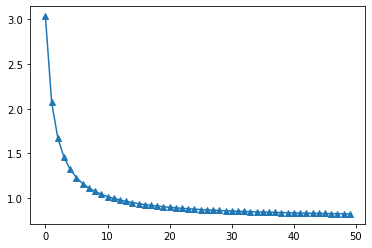

In [ ]:
# SVD++ gradient curve
plt.plot(loss_history, "-^")

In [ ]:
# evalution
final_result = model.evaluate(test_input, test_output) # final RMSE score
final_result

0.9367524781629404